# Напоминание из теории

В случае оптимального байесовского классификатора разделяющая поверхность будет задаваться уравнением

$$
\mathbb{P}(C_1|x) = \mathbb{P}(C_2|x) \Longleftrightarrow \mathbb{P}(x|C_1)\mathbb{P}(C_1) = \mathbb{P}(x|C_2)\mathbb{P}(C_2).
$$

Теперь обсудим пример построения порождающей модели. Естественно, на основе нормального распределения или гауссианов. Пусть

$$
\mathbb{P}(x|C_i) = \mathbb{N}(x|\mu_i, \Sigma_i).
$$

Разделяющая поверхность будет иметь вид

$$
\ln \mathbb{P}(C_1) - \frac{1}{2}\ln |\Sigma_1| - \frac{1}{2}(x-\mu_1)^{T}\Sigma_1^{-1}(x-\mu_1) = \ln \mathbb{P}(C_2) - \frac{1}{2}\ln |\Sigma_2| - \frac{1}{2}(x-\mu_2)^{T}\Sigma_2^{-1}(x-\mu_2).
$$

Понятно, что разделяющая поверхность квадратичная. Для оценки параметров $\mu_i$ и $\Sigma_i$ имеет смысл использовать соответствующие выборочные характеристики (выборочное среднее и выборочная ковариационная матрица). Оценить $\mathbb{P}(C_i)$ можно долей числа элементов соответствующего класса.

# QDA

Напомним выражение для резделяющей поверхности:

$$
\ln \mathbb{P}(C_1) - \frac{1}{2}\ln |\Sigma_1| - \frac{1}{2}(x-\mu_1)^{T}\Sigma_1^{-1}(x-\mu_1) = \ln \mathbb{P}(C_2) - \frac{1}{2}\ln |\Sigma_2| - \frac{1}{2}(x-\mu_2)^{T}\Sigma_2^{-1}(x-\mu_2).
$$

Будем называть каждую из частей уравнения **дискриминантной функцией** класса $1$ и $2$ соответственно.

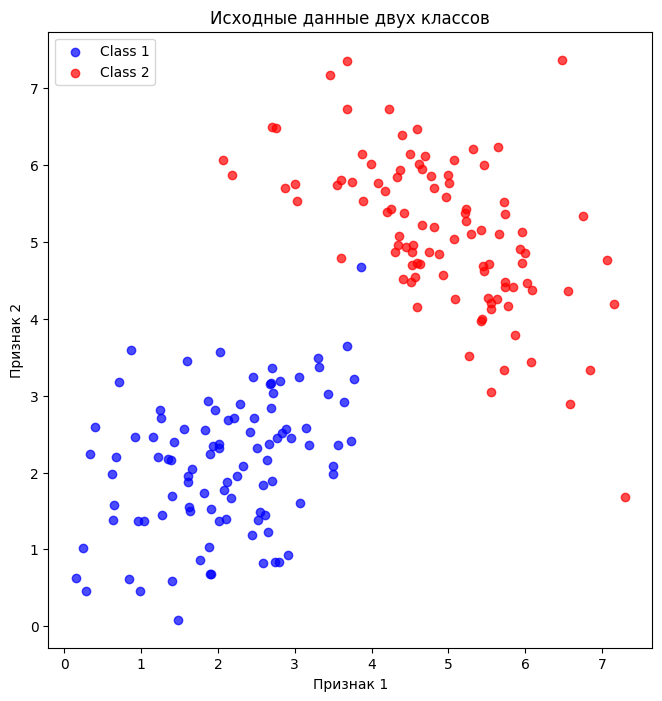

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Генерация данных
np.random.seed(42)

class_1_size = 100
class_2_size = 100

class_1 = np.random.multivariate_normal(mean=[2, 2], cov=[[1, 0.5], [0.5, 1]], size=class_1_size)
class_2 = np.random.multivariate_normal(mean=[5, 5], cov=[[1, -0.5], [-0.5, 1]], size=class_2_size)

# Объединение данных
X = np.vstack((class_1, class_2))
y = np.hstack((np.zeros(100), np.ones(100)))

# Визуализация данных
plt.figure(figsize=(8,8))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.7)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.7)
plt.legend()
plt.title('Исходные данные двух классов')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.axis('scaled')
plt.show()

## Вычисление параметров модели

In [ ]:
# Оценка среднего

def get_mu(class_objects):
  """
  Параметры
  ----------
  class_objects : {array-like} формы (n_samples, n_features)
      Объекты одного класса, где `n_samples` — число объектов
      и `n_features` — число признаков.

  Что возвращается
  -------
  mu : вектор из координат центроида класса
  """
  mu = np.mean(class_objects, axis=0)
  return mu

mu_1 = get_mu(class_1)
mu_2 = get_mu(class_2)

assert np.isclose(mu_1, np.array([2.08307042, 2.11709274])).all() and np.isclose(mu_2, np.array([4.91067717, 5.13281048])).all()

In [ ]:
# Внутриклассовая матрица ковараций

def get_Sigma(class_elements, mu):
  """
  Параметры
  ----------
  class_elements : {array-like} формы (n_samples, n_features)
      Объекты данного класса, где `n_samples` — число объектов
      и `n_features` — число признаков.
  mu : {numpy.ndarray} — вектор из координат центроида данного класса

  Что возвращается
  -------
  Sigma : матрица ковариаций данного класса
  """
  Sigma = ((class_elements - mu).T @ (class_elements - mu))/len(class_elements)
  return Sigma

Sigma_1 = get_Sigma(class_1, mu_1)
Sigma_2 = get_Sigma(class_2, mu_2)

assert np.isclose(Sigma_1, np.array([[0.8150929 , 0.29751939],[0.29751939, 0.76768711]])).all() and np.isclose(Sigma_2, np.array([[ 1.08836645, -0.58617111], [-0.58617111,  0.94906895]])).all()

In [ ]:
# Оценка вероятностей классов

def get_prior(class_1, class_2):
  """
  Параметры
  ----------
  class_1 : {array-like} формы (n_samples, n_features)
      Объекты класса 1, где `n_samples` — число объектов
      и `n_features` — число признаков.
  class_2 : {array-like} формы (n_samples, n_features)
      Объекты класса 2, где `n_samples` — число объектов
      и `n_features` — число признаков.

  Что возвращается
  -------
  (prior_1, prior_2) : кортеж, состоящий из оценок вероятностей классов 1 и 2
  """
  prior_1 = len(class_1)/(len(class_1)+len(class_2))
  prior_2 = len(class_2)/(len(class_1)+len(class_2))
  return (prior_1, prior_2)

prior_1, prior_2 = get_prior(class_1, class_2)

assert np.isclose(np.array([prior_1, prior_2]), np.array([0.5, 0.5])).all()

In [ ]:
# Вычисление дискриминантной функции

def get_discriminant(x, Sigma, mu, prior):
    """
    Параметры
    ----------
    x : {array-like} вектор n_features
        Один объект данных, где `n_features` — число признаков.
    Sigma : матрица ковариаций данного класса
    mu : {numpy.ndarray} — вектор из координат центроида данного класса
    prior : оценка вероятности данного класса

    Что возвращается
    -------
    discriminant : значение дискриминантной функции для данного класса в точке x
    """
    discriminant = np.log(prior) - 0.5*np.log(np.linalg.det(Sigma)) - 0.5*((x - mu).T@np.linalg.inv(Sigma)@(x - mu))
    return discriminant

assert np.isclose(get_discriminant(X[0], Sigma_1, mu_1, prior_1), -0.6600206493124732)

  0%|          | 0/200 [00:00<?, ?it/s]

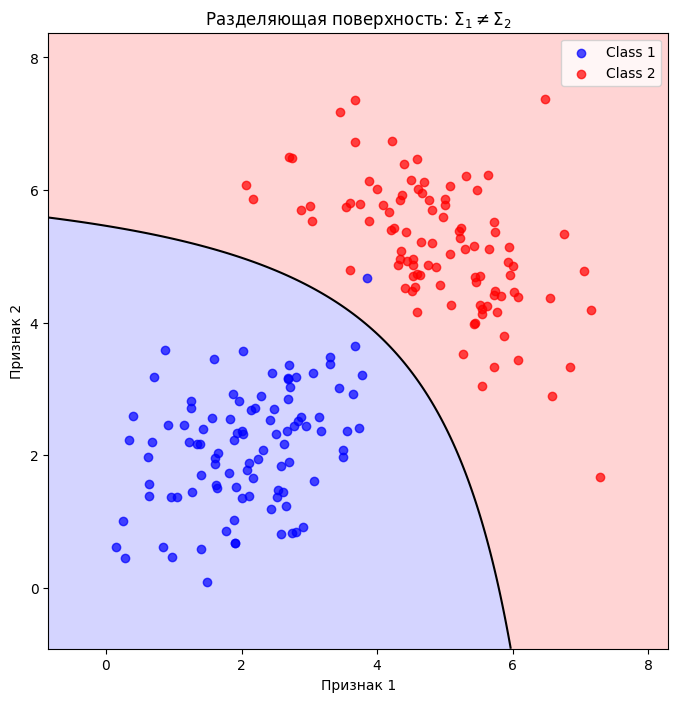

In [ ]:
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm

# Создание сетки для визуализации разделяющей поверхности
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Вычисление квадратичного уравнения для каждой точки сетки
Z = np.zeros_like(xx)
for i in tqdm(range(xx.shape[0])):
    for j in range(xx.shape[1]):
        x = np.array([xx[i, j], yy[i, j]])

        # Разница дискриминантных функций
        Z[i, j] = get_discriminant(x, Sigma_1, mu_1, prior_1) - get_discriminant(x, Sigma_2, mu_2, prior_2)

# Построение графика разделяющей кривой
plt.figure(figsize=(8,8))
plt.contourf(xx, yy, Z, levels=0, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.5)
plt.contour(xx, yy, Z, levels=[0], colors='black')
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.7)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.7)
plt.legend()
plt.title('Разделяющая поверхность: $\Sigma_1 \\neq \Sigma_2$')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()